In [1]:
#!/usr/bin/env python3
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.utils import plot_model
import IPython.display
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
#if i want to speed up and use one file
#files2 = "CSVLog_20190518_122417.csv"

#i aggregate the data points for five files into aggregate.csv. i have removed the time predictor from the data set
files = "aggregate_no_time_column.csv"

raw_dataset = pd.read_csv(files, sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()

#remove whitespace in front of column name
dataset.columns = dataset.columns.str.lstrip()

In [3]:
dataset.tail()

,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Ignition timing advance for #1 cylinder (deg),Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG),Total fuel economy (MPG)
6633,18.03922,11.76471,59.0,29.8254,29.01961,885.903,183.2,658.75,67.05882,424.9606,0.994239,5.0,71.6,11.51674,-0.78125,0.308259,0.0,0.205909,0.0,30.11613
6634,17.64706,11.76471,59.0,29.8254,29.01961,885.903,183.2,640.00,67.05882,449.6170,0.994239,4.5,71.6,11.51674,-0.78125,0.257985,0.0,0.172327,0.0,30.11534
6635,17.64706,11.37255,59.0,29.8254,29.41176,885.903,183.2,607.75,67.05882,429.3117,0.994239,4.0,71.6,11.51674,-0.78125,0.325458,0.0,0.217398,0.0,30.11455
6636,17.25490,11.37255,59.0,29.8254,29.41176,885.903,183.2,606.75,67.05882,449.6170,0.994239,6.5,71.6,11.51674,-0.78125,0.239463,0.0,0.159955,0.0,30.11384
6637,17.64706,11.37255,59.0,29.8254,29.80392,885.903,183.2,604.50,67.05882,429.3117,0.994239,6.0,71.6,11.51674,-0.78125,0.227556,0.0,0.152002,0.0,30.11316


In [4]:
%%time 
#set seed here!

#creating data and splitting and random shuffling
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

np.random.seed(88)
train, validate, test = train_validate_test_split(dataset)

train_labels = train.pop("Total fuel economy (MPG)")
validate_labels = validate.pop("Total fuel economy (MPG)")
test_labels = test.pop("Total fuel economy (MPG)")


CPU times: user 4.45 ms, sys: 4.95 ms, total: 9.4 ms
Wall time: 8.03 ms


In [5]:
#test_labels
#train.dtypes

In [6]:
train = train.apply(lambda col:pd.to_numeric(col, errors='coerce'))
train_stats = train.describe(include = 'all')
#train_stats = train.transpose()
train_stats


,Absolute load value (%),Absolute throttle position (%),Ambient air temperature (F),Barometric pressure (inHg),Calculated load value (%),Commanded fuel rail pressure A (inHg),Engine coolant temperature (F),Engine RPM (RPM),Fuel level input (%),Fuel rail pressure (psi),Fuel/Air commanded equivalence ratio,Ignition timing advance for #1 cylinder (deg),Intake air temperature (F),Intake manifold absolute pressure (inHg),Long term fuel % trim - Bank 1 (%),Mass air flow rate (lb/min),Vehicle speed (MPH),Fuel rate (gal/hr),Instant fuel economy (MPG)
count,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000
mean,34.765365,21.341330,67.695429,29.726472,42.617465,1844.860021,185.631592,1512.254332,74.660482,922.304889,0.981457,21.181065,73.401457,17.569520,5.335337,1.484214,31.360988,1.002811,61.641141
std,24.278678,13.898859,12.542581,0.509203,26.284888,1166.247340,7.621659,643.830795,10.860770,568.094712,0.031924,15.263267,13.998863,8.846116,3.947341,1.565152,22.609982,1.053180,79.944052
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.893070,-10.000000,0.000000,0.000000,-2.343750,0.050274,0.000000,0.033585,0.000000
25%,16.078430,12.156860,62.600000,29.530100,20.000000,885.903000,183.200000,1075.937500,67.450980,478.624500,0.990426,4.500000,64.400000,9.744933,2.343750,0.312559,11.184680,0.209994,11.185377
50%,24.705880,15.294120,62.600000,29.825400,38.823530,1213.687000,185.000000,1480.250000,74.509800,617.860800,0.993202,24.500000,68.000000,15.060350,5.468750,0.792477,31.068560,0.542141,32.477560
75%,49.411770,26.666670,66.200000,29.825400,56.470590,2571.333750,188.600000,1982.937500,81.176470,1261.828000,0.995550,35.500000,77.000000,27.167690,7.812500,2.217348,45.981470,1.494769,85.577900
max,99.215680,90.980390,118.400000,30.120700,100.000000,5906.020000,204.800000,4719.500000,93.333340,2981.976000,1.016260,47.500000,122.000000,30.416000,12.500000,11.959920,76.428660,8.026347,1128.966000


In [7]:
type(train_stats)

pandas.core.frame.DataFrame

In [8]:
#https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
scaler = StandardScaler()
normed_train = scaler.fit_transform(train)
normed_validate = scaler.fit_transform(validate)
normed_test = scaler.fit_transform(test)

#not technically correct
#from tf regression website
#Note: Although we intentionally generate these statistics from only the training dataset, 
#these statistics will also be used to normalize the test dataset. We need to do that to project the test 
#dataset into the same distribution that the model has been trained on.

#I normalize it according to the mean and sd of each predictor from each set instead of normalizaing from 
#training set only

In [9]:
#debugging
#normed_train

In [10]:
def build_model_A():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def build_model_B():
  model = keras.Sequential([
    layers.Dense(20, activation=tf.nn.relu, input_shape=[len(train.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model


In [11]:
%%time
model_A = build_model_A()
model_A.summary()
model_B = build_model_B()
model_B.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 100       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 421
Trainable params: 421
Non-trainable params: 0
__________________________

In [12]:
%%time
#change batch size?
#try early stop?
# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history_object = model.fit(train, train_labels, epochs=100, verbose=2,
#         validation_data=(validate, validate_labels), callbacks=[early_stop])

history_object_A = model_A.fit(normed_train, train_labels, epochs=50, verbose=2,
         validation_data=(normed_validate, validate_labels))


Train on 3982 samples, validate on 1327 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 0s - loss: 819.9451 - mean_absolute_error: 28.4216 - mean_squared_error: 819.9451 - val_loss: 774.8294 - val_mean_absolute_error: 27.5572 - val_mean_squared_error: 774.8295
Epoch 2/50
 - 0s - loss: 747.0297 - mean_absolute_error: 26.9810 - mean_squared_error: 747.0297 - val_loss: 703.9538 - val_mean_absolute_error: 26.0463 - val_mean_squared_error: 703.9539
Epoch 3/50
 - 0s - loss: 679.0713 - mean_absolute_error: 25.3801 - mean_squared_error: 679.0714 - val_loss: 640.2534 - val_mean_absolute_error: 24.3578 - val_mean_squared_error: 640.2535
Epoch 4/50
 - 0s - loss: 621.1198 - mean_absolute_error: 23.6669 - mean_squared_error: 621.1198 - val_loss: 587.9225 - val_mean_absolute_error: 22.6557 - val_mean_squared_error: 587.9224
Epoch 5/50
 - 0s - loss: 573.6425 - mean_absolute_error: 22.1886 - mean_squared_error: 573.6425 - val_loss: 544.3721 - val_mean_absolute_error: 21.4461 - va

Epoch 45/50
 - 0s - loss: 4.9715 - mean_absolute_error: 1.6500 - mean_squared_error: 4.9715 - val_loss: 6.9526 - val_mean_absolute_error: 1.7824 - val_mean_squared_error: 6.9526
Epoch 46/50
 - 0s - loss: 4.8653 - mean_absolute_error: 1.6333 - mean_squared_error: 4.8653 - val_loss: 6.9590 - val_mean_absolute_error: 1.7925 - val_mean_squared_error: 6.9590
Epoch 47/50
 - 0s - loss: 4.7407 - mean_absolute_error: 1.6085 - mean_squared_error: 4.7407 - val_loss: 6.8234 - val_mean_absolute_error: 1.7781 - val_mean_squared_error: 6.8234
Epoch 48/50
 - 0s - loss: 4.6267 - mean_absolute_error: 1.5924 - mean_squared_error: 4.6267 - val_loss: 6.8333 - val_mean_absolute_error: 1.7597 - val_mean_squared_error: 6.8333
Epoch 49/50
 - 0s - loss: 4.5303 - mean_absolute_error: 1.5655 - mean_squared_error: 4.5303 - val_loss: 6.4966 - val_mean_absolute_error: 1.7277 - val_mean_squared_error: 6.4966
Epoch 50/50
 - 0s - loss: 4.4304 - mean_absolute_error: 1.5514 - mean_squared_error: 4.4304 - val_loss: 6.5323

In [13]:
%%time
history_object_B = model_B.fit(normed_train, train_labels, epochs=50, verbose=2,
         validation_data=(normed_validate, validate_labels))

Train on 3982 samples, validate on 1327 samples
Epoch 1/50
 - 0s - loss: 773.9948 - mean_absolute_error: 27.6219 - mean_squared_error: 773.9949 - val_loss: 677.3340 - val_mean_absolute_error: 25.7858 - val_mean_squared_error: 677.3341
Epoch 2/50
 - 0s - loss: 595.0250 - mean_absolute_error: 24.0686 - mean_squared_error: 595.0250 - val_loss: 496.1649 - val_mean_absolute_error: 21.8002 - val_mean_squared_error: 496.1649
Epoch 3/50
 - 0s - loss: 413.3285 - mean_absolute_error: 19.5667 - mean_squared_error: 413.3284 - val_loss: 323.3724 - val_mean_absolute_error: 16.8896 - val_mean_squared_error: 323.3725
Epoch 4/50
 - 0s - loss: 252.4994 - mean_absolute_error: 14.5458 - mean_squared_error: 252.4994 - val_loss: 187.0215 - val_mean_absolute_error: 11.9772 - val_mean_squared_error: 187.0215
Epoch 5/50
 - 0s - loss: 140.8039 - mean_absolute_error: 9.8910 - mean_squared_error: 140.8039 - val_loss: 112.2425 - val_mean_absolute_error: 8.3710 - val_mean_squared_error: 112.2425
Epoch 6/50
 - 0s - 

Epoch 47/50
 - 0s - loss: 2.4696 - mean_absolute_error: 1.1272 - mean_squared_error: 2.4696 - val_loss: 7.5050 - val_mean_absolute_error: 1.3776 - val_mean_squared_error: 7.5050
Epoch 48/50
 - 0s - loss: 2.4222 - mean_absolute_error: 1.1109 - mean_squared_error: 2.4222 - val_loss: 7.3141 - val_mean_absolute_error: 1.3691 - val_mean_squared_error: 7.3141
Epoch 49/50
 - 0s - loss: 2.3941 - mean_absolute_error: 1.1015 - mean_squared_error: 2.3941 - val_loss: 7.4445 - val_mean_absolute_error: 1.3632 - val_mean_squared_error: 7.4445
Epoch 50/50
 - 0s - loss: 2.3431 - mean_absolute_error: 1.0935 - mean_squared_error: 2.3431 - val_loss: 7.7500 - val_mean_absolute_error: 1.4103 - val_mean_squared_error: 7.7500
CPU times: user 11 s, sys: 3.13 s, total: 14.1 s
Wall time: 7.18 s


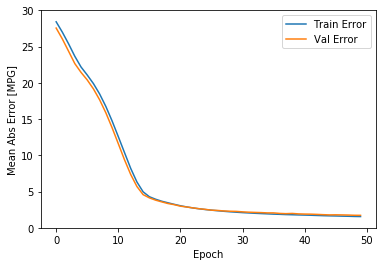

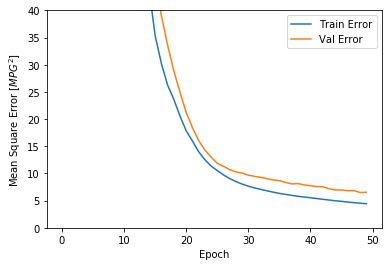

In [14]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,30])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,40])
  plt.legend()
  plt.show()

plot_history(history_object_A)

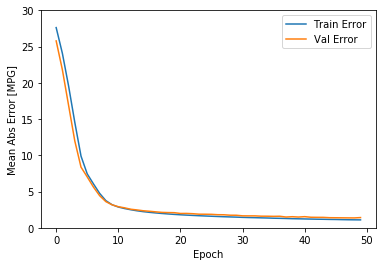

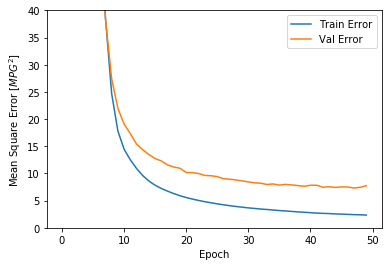

In [15]:
plot_history(history_object_B)